In [1]:
from qiskit.circuit import ParameterVector, Parameter
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, execute, IBMQ, Aer
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit.primitives import Estimator
from qiskit_aer import AerSimulator
from qiskit.algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.quantum_info import SparsePauliOp, Statevector, state_fidelity
from qiskit.primitives import BackendEstimator
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
from quspin.tools.measurements import obs_vs_time
from scipy.optimize import minimize
from numpy.random import default_rng
from qiskit.providers.fake_provider import FakeAthensV2
from qiskit.tools.visualization import plot_histogram
from importlib import reload
import time
from sympy import pprint, Matrix

plt.rcParams['font.family']="arial unicode ms"

pi = np.pi

import topological_dynamics 
import exact_diagonalization
LoschmidtEcho = topological_dynamics.LoschmidtEcho
ExactDiagonalization = exact_diagonalization.ExactDiagonalization
compare_fidelity = exact_diagonalization.compare_fidelity

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
J = 1
m = 1
w = 1
num_qubits = 4
theta = 0

del_theta = 4*pi
duration=0.6

reload(topological_dynamics)
reload(exact_diagonalization)

LoschmidtEcho = topological_dynamics.LoschmidtEcho
ExactDiagonalization = exact_diagonalization.ExactDiagonalization

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 

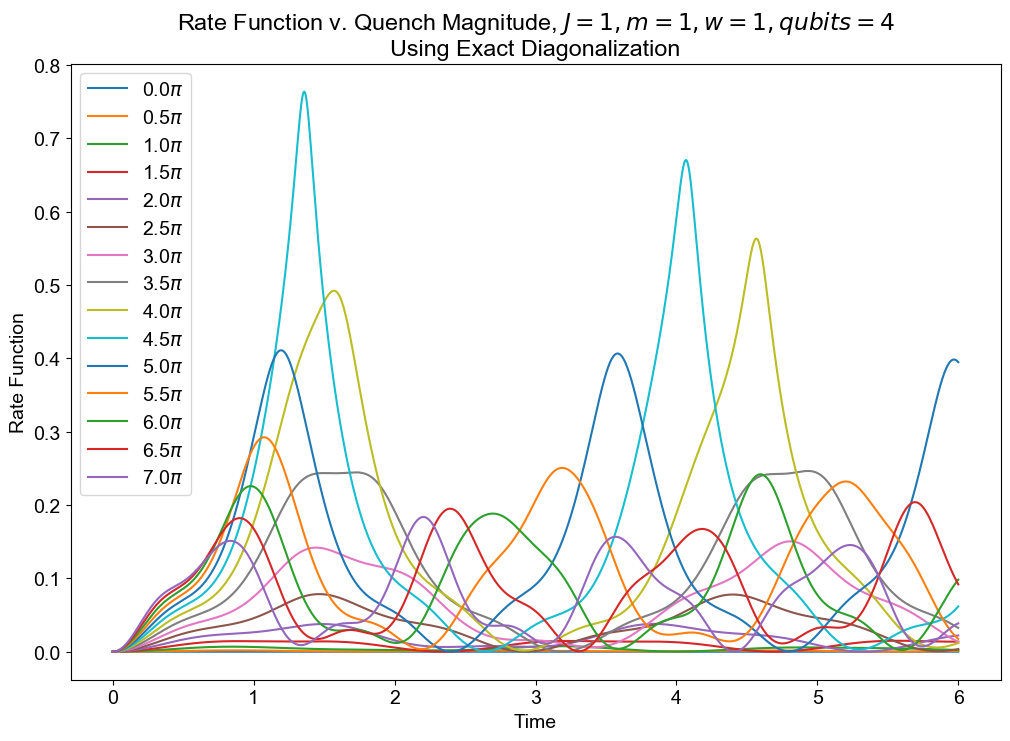

In [11]:
num_qubits = 4
ed = ExactDiagonalization(num_qubits=num_qubits, theta=theta, J=J, m=m, w=w)
plt.figure(figsize=(12, 8))
plt.title(f"Rate Function v. Quench Magnitude, $J = {J}, m = {m}, w = {w}, qubits = {num_qubits}$\nUsing Exact Diagonalization")
for i in range(15):
    quench = i/2
    rf_ed, time_ed = ed.ratefunction(quench*pi, start=0, end=6, steps=3000)
    plt.plot(time_ed, rf_ed, label = f"{round(quench, 2)}$\\pi$")
    print(i, end=" ")

plt.xlabel("Time")
plt.ylabel("Rate Function")
plt.legend()
plt.show()

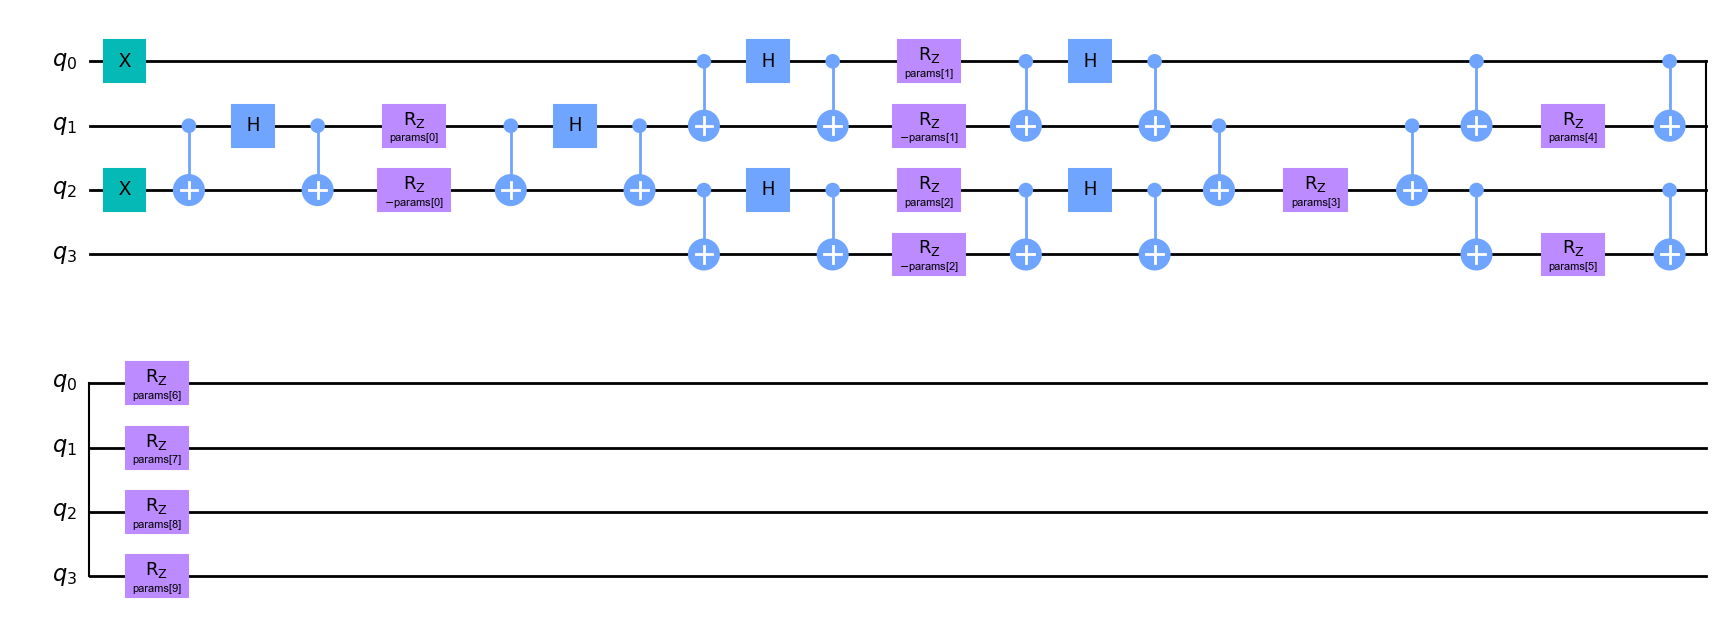

In [13]:
## Definition of the LoschmidtEcho class.

LE = LoschmidtEcho(num_qubits=num_qubits, theta = theta, backend=AerSimulator(), J=J, m=m, w=w)
LE.ansatz_XXYY()
LE.ansatz_ZZ()
LE.ansatz_Z()

LE.ansatz.draw("mpl") ## draw ansatz of the circuit

In [14]:
## Initialize the ExactDiagonalization class under the same condition
ed = ExactDiagonalization(num_qubits, theta, J, m, w)
ed.initialize()
state = list(ed.init_state)
state.reverse()
state_ed = Statevector(state)

0 step1 finished
0 step2 finished
0 step3 finished
0 step4 finished
0 step5 finished
0 step0 finished


Text(0.5, 0.98, 'VQE Performance versus Number of Shots\n Horizontal Axis: Number of Steps, Vertical Axis: Energy\n $J = 1, m = 1, w = 1, qubits = 4$')

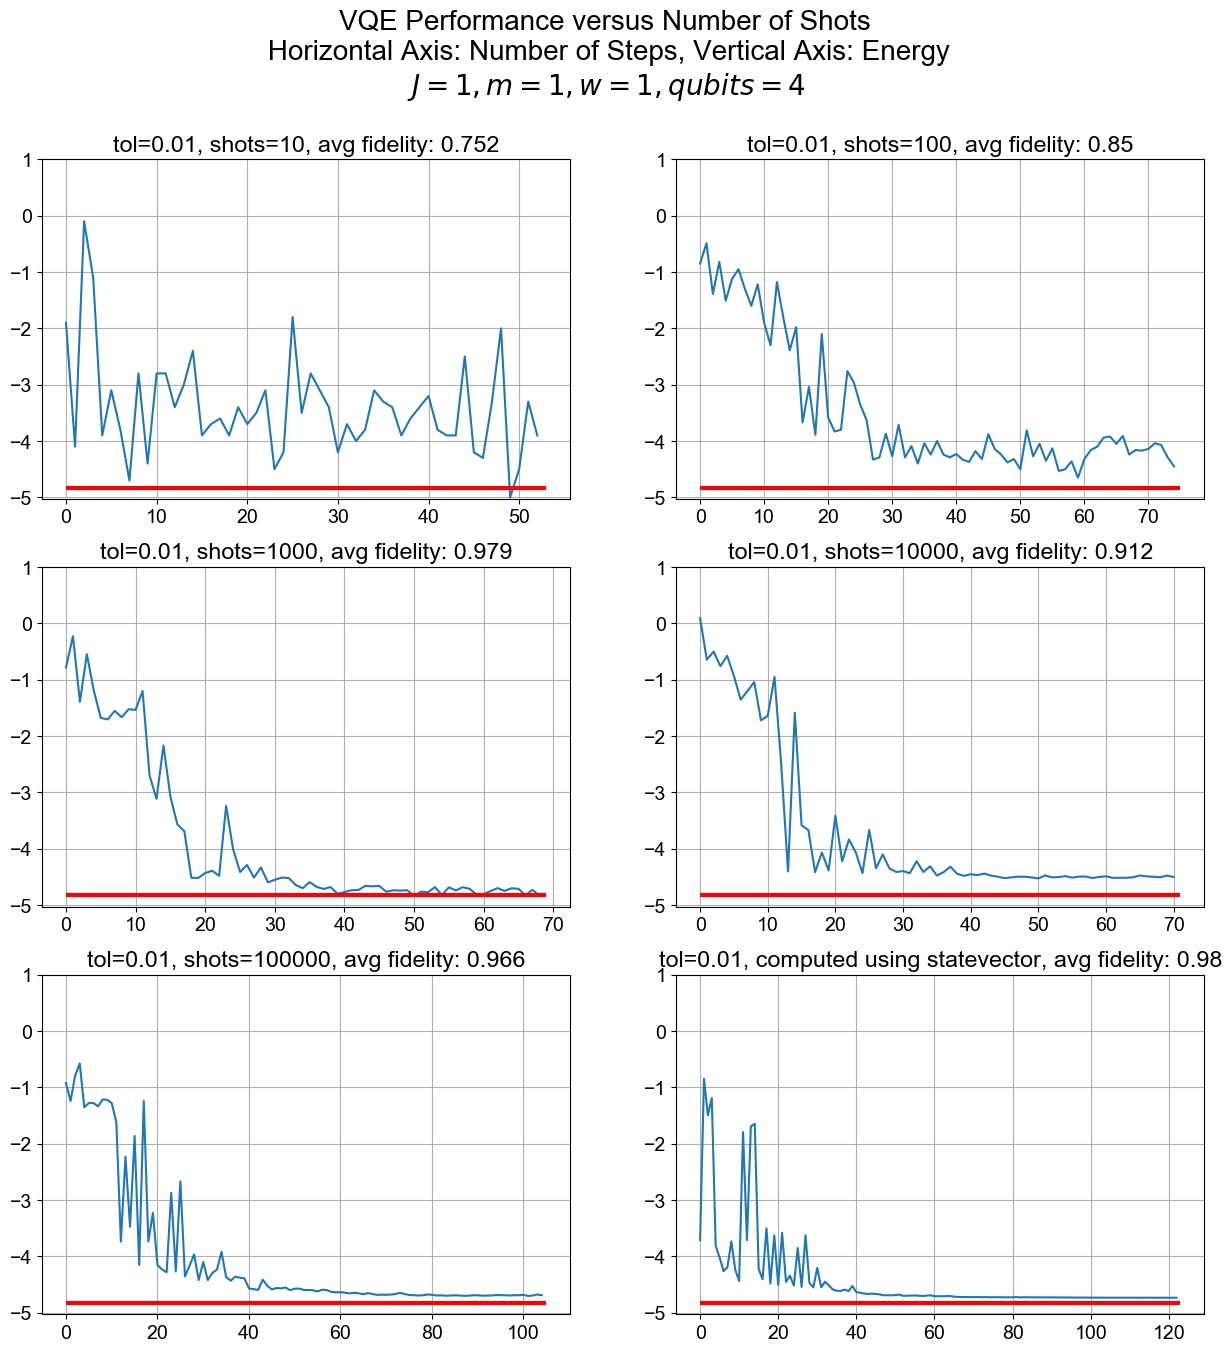

In [15]:
## Initialize the Loschmidt Echo Class using VQE

fig, axs = plt.subplots(3, 2, figsize = (15, 15))
fid_states = []

rep_number = 1


for i, ax, statevector in [(1, axs[0,0], False), (2, axs[0,1], False), (3, axs[1,0], False), (4, axs[1,1], False), (5, axs[2,0], False), (0, axs[2, 1], True)]:
    max_ed = 0
    fid_state = []

    for j in range(rep_number):
        LE.initialize_VQE(shots=int(10**i), statevector=statevector)
        qc = LE.ansatz.bind_parameters({LE.params: LE.init_parameters})
        state_vqe = Statevector(qc)
        fid_state.append(state_fidelity(state_ed, state_vqe))
        ax.plot(LE.cost_val_list)
        max_ed = max(max_ed, len(LE.cost_val_list))
        print(j, end=" ")

    fid_states.append(fid_state)
    fid = sum(fid_state)/rep_number

    ax.hlines(ed.init_energy, max_ed, 0, label = "ED", colors="r", lw=3)
    ax.set_title((f"tol=0.01, shots={int(10**i)}" if not statevector else f"tol=0.01, computed using statevector")+f", avg fidelity: {round(fid, 3)}")
    ax.set_ylim([ed.init_energy-0.2, 1])
    ax.grid()
    print(f"step{i} finished")


fid_states = np.array(fid_states)
# np.save("File Name", fid_states)

fig.suptitle(f"VQE Performance versus Number of Shots\n Horizontal Axis: Number of Steps, Vertical Axis: Energy\n $J = {J}, m = {m}, w = {w}, qubits = {num_qubits}$", fontsize=20)

# fig.savefig("File Name")

In [17]:
## Do VQS to gain the time evolution. This takes around 1-2 hours if steps = 500, shots = 10000

steps=1
shots = 10000

LE.quench(del_theta, duration, steps, shots) # statevector = True if doing the VQS by statevector
# np.save("file name", LE.params_list) to save the quenched parameters

0/10 1/10 2/10 3/10 4/10 5/10 6/10 7/10 8/10 9/10 step 0 finished 

0/3001 100/3001 200/3001 300/3001 400/3001 500/3001 600/3001 700/3001 800/3001 900/3001 1000/3001 1100/3001 1200/3001 1300/3001 1400/3001 1500/3001 1600/3001 1700/3001 1800/3001 1900/3001 2000/3001 2100/3001 2200/3001 2300/3001 2400/3001 2500/3001 2600/3001 2700/3001 2800/3001 2900/3001 3000/3001 

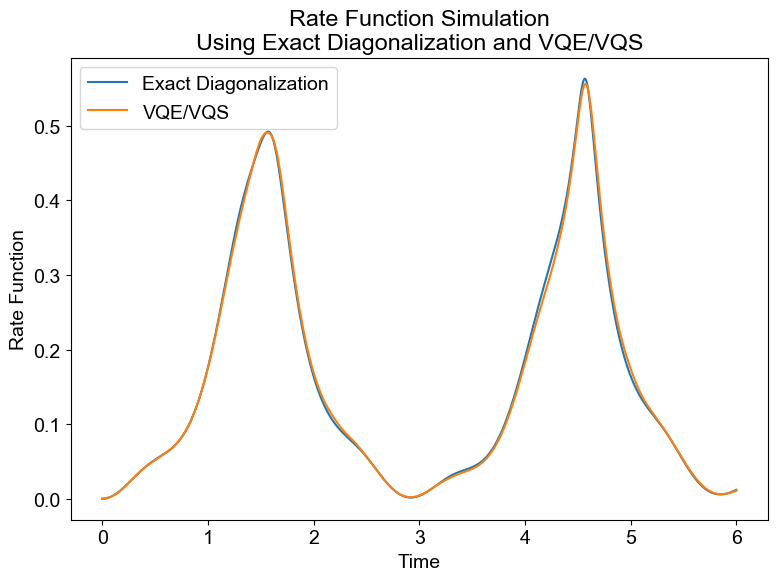

In [24]:
duration = 6
LE.load_params("LE_params_statevector_steps_3000_J1_m1_w1_numqubits4_theta0_deltheta4pi_duration6_initfid0_999801.npy") ## load your parameters if needed. don't forget to set self.time_list too.
LE.time_list = np.linspace(0, duration, 3001)
rf_vqsvqe, time_vqsvqe = LE.ratefunction(statevector=True)

## quench result. plot the rate function 
ed = ExactDiagonalization(num_qubits, theta, J, m, w)
rf_ed, time_ed = ed.ratefunction(del_theta, 0, duration, 1000)

plt.figure(figsize=(9, 6))
plt.plot(time_ed, rf_ed, label = "Exact Diagonalization")
plt.plot(time_vqsvqe, rf_vqsvqe, label = "VQE/VQS")
plt.legend()
plt.title("Rate Function Simulation\nUsing Exact Diagonalization and VQE/VQS")
plt.xlabel("Time")
plt.ylabel("Rate Function")
plt.show()

/Users/aeshintaro/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


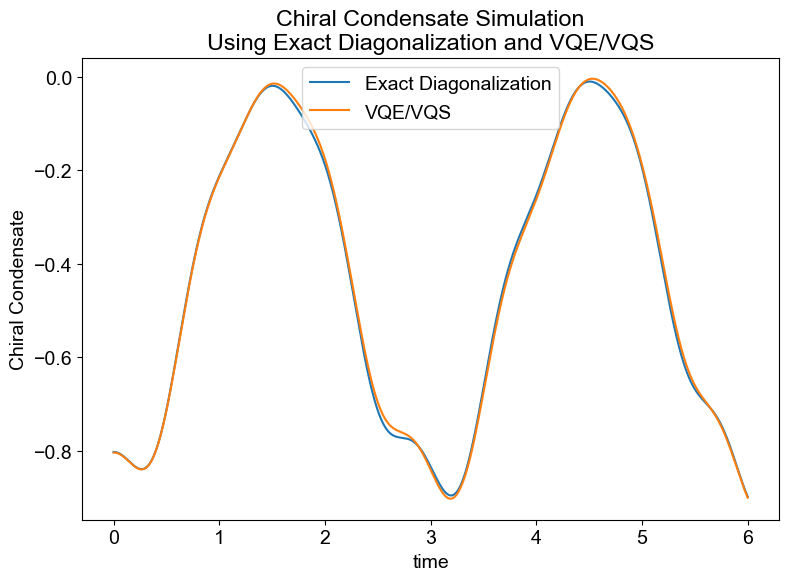

In [23]:
## Chiral Condensate can be simulated too.

#using ExactDiagonalization
ed = ExactDiagonalization(num_qubits=num_qubits, theta=theta, J=J, w=w, m=m)
cc_ED, time_ED = ed.chiral_condensate(del_theta=del_theta, duration=duration, steps=6100)

#using LoschmidtEcho
cc_LE, time_LE = LE.chiral_condensate(statevector=True)


plt.figure(figsize=(9, 6))
plt.plot(time_ED, cc_ED, label="Exact Diagonalization")
plt.xlabel("time")
plt.ylabel("Chiral Condensate")
plt.title("Chiral Condensate Simulation\nUsing Exact Diagonalization and VQE/VQS")
plt.plot(time_LE, cc_LE, label = "VQE/VQS")
plt.legend()
plt.show()

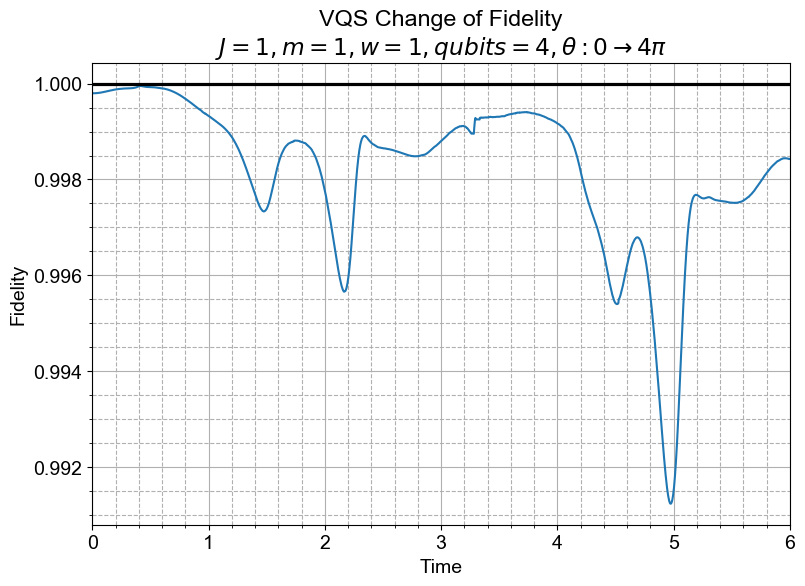

In [29]:
# You can get a 

fidelity, time_list = compare_fidelity(LE, del_theta)

plt.figure(figsize = [9, 6])
plt.plot(time_list, fidelity)
plt.hlines(1, 0, 6, colors='black', lw=2.3)
plt.xlim([0, 6])
plt.title(f"VQS Change of Fidelity\n$J = {J}, m = {m}, w = {w}, qubits = {num_qubits}, \\theta: 0\\rightarrow 4\pi$")
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.minorticks_on()
plt.grid(which='major', linestyle="-")
plt.grid(which='minor', linestyle='--')
plt.show()